## Kaggle Competetion, Season 5 Episode 5

## Predicting Calori Expenditure 

**Overview:**
welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

* The goal is to predict how many calories were burned during a workout.

## Evaluation 
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

## Submission File
For each id row in the test set, you must predict the continuous target, Calories

## Preparing the tools 
* We are going to import the tools needed 

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error

## Load the Data 

In [122]:
## Let's import our train and test data 

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [123]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [124]:
len(train_df), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


(750000, None)

In [125]:
train_df.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [126]:
train_df['Calories'].value_counts()

Calories
7.0      8350
13.0     7261
11.0     6982
12.0     6951
17.0     6946
         ... 
280.0      41
289.0      32
300.0      32
273.0      29
314.0      26
Name: count, Length: 277, dtype: int64

In [127]:
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


**Since the goal of the project is to predict the calories expended during body exercise, let's goahead to make our predictions.**
* Before, we make predictions, let's convert te categorical data in the train and test data to numbers.

In [128]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
train_df['Sex']= Encoder.fit_transform(train_df['Sex'])

In [129]:
train_df['Sex'].head()

0    1
1    0
2    0
3    1
4    0
Name: Sex, dtype: int64

In [130]:
test_df['Sex'] = Encoder.fit_transform(test_df['Sex'])
test_df['Sex'].head()

0    1
1    1
2    0
3    0
4    0
Name: Sex, dtype: int64

## Exploratory Data Analysis

In [131]:
## Let's check correlation between the data sets
train_df.corr()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,1.000000,-0.000065,0.002330,0.000101,0.000524,0.001647,0.001092,0.001612,0.001148
Sex,-0.000065,1.000000,0.009689,0.755906,0.818250,-0.009594,0.009122,-0.015933,0.012011
Age,0.002330,0.009689,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275,0.145683
Height,0.000101,0.755906,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641,-0.004026
Weight,0.000524,0.818250,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717,0.015863
Duration,0.001647,-0.009594,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066,0.959908
Heart_Rate,0.001092,0.009122,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972,0.908748
Body_Temp,0.001612,-0.015933,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000,0.828671
Calories,0.001148,0.012011,0.145683,-0.004026,0.015863,0.959908,0.908748,0.828671,1.000000


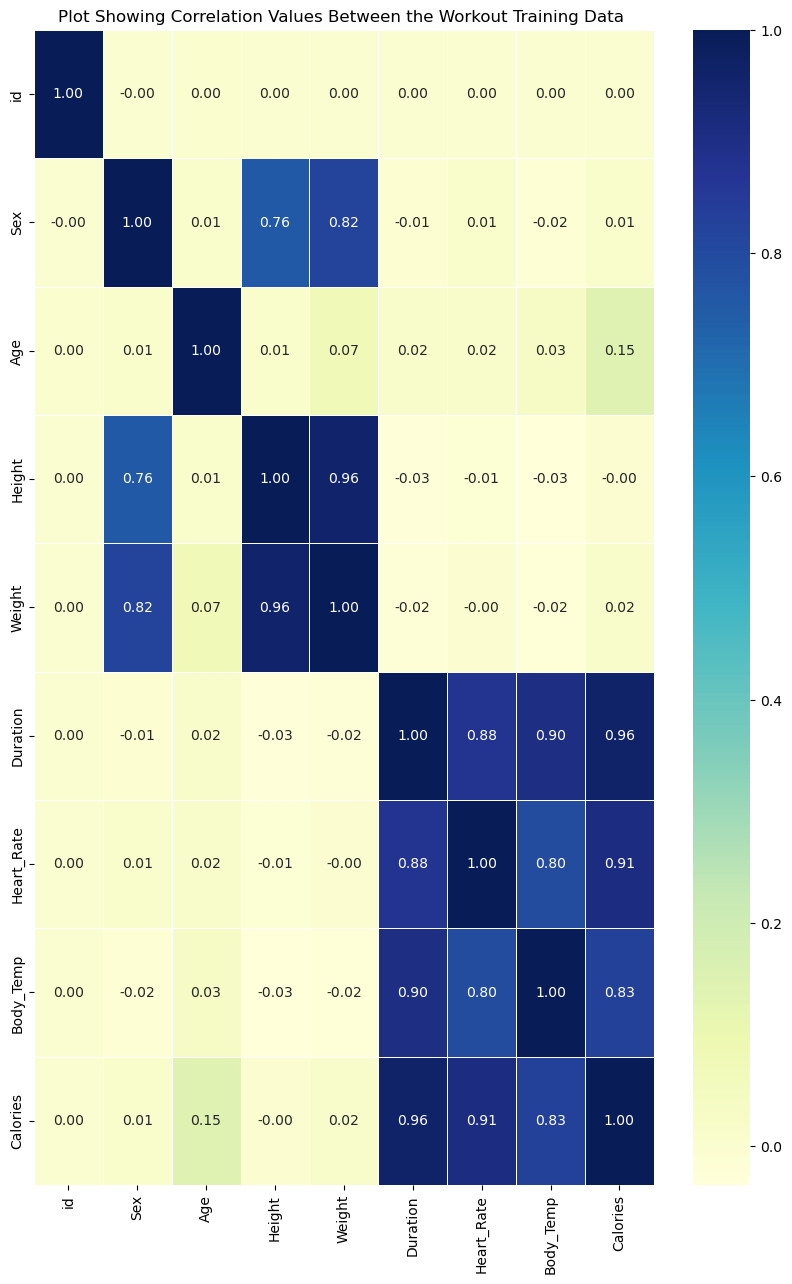

In [132]:
## let's make a plot of the correlation
fig, ax = plt.subplots(figsize=[10, 15])
ax = sns.heatmap(train_df.corr(),
                 annot = True,
                 fmt = '.2f',
                 linewidths=0.5,
                cmap = 'YlGnBu')
plt.title('Plot Showing Correlation Values Between the Workout Training Data ');

In [133]:
## Let's make a bar plot with 10% of the train data 
# let's fist shuffle that data
np.random.seed(42)
train_shuffled = train_df.sample(frac=1).reset_index(drop=True)
x_0 = train_shuffled.sample(frac=0.1)
x_0.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
692242,399423,0,21,168.0,67.0,25.0,100.0,40.7,133.0
77818,524295,1,52,179.0,79.0,26.0,102.0,40.6,166.0
117920,714408,0,20,174.0,78.0,2.0,93.0,38.2,9.0
542429,467767,0,30,153.0,55.0,26.0,100.0,40.9,141.0
531023,107577,0,26,161.0,60.0,23.0,105.0,40.7,140.0


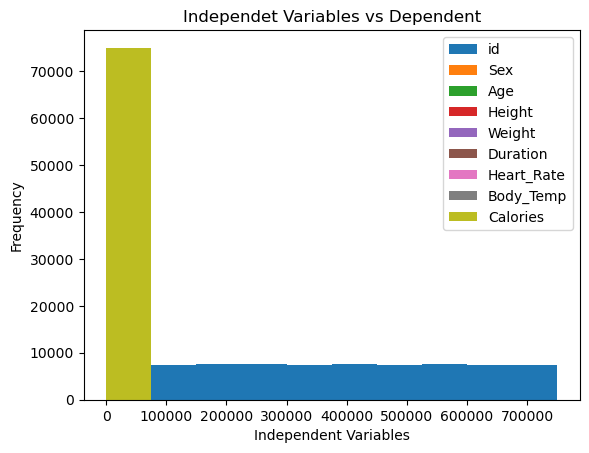

In [134]:
x_0.plot.hist()
plt.title('Independet Variables vs Dependent')
plt.xlabel('Independent Variables');

In [135]:
x_0.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
692242,399423,0,21,168.0,67.0,25.0,100.0,40.7,133.0
77818,524295,1,52,179.0,79.0,26.0,102.0,40.6,166.0
117920,714408,0,20,174.0,78.0,2.0,93.0,38.2,9.0
542429,467767,0,30,153.0,55.0,26.0,100.0,40.9,141.0
531023,107577,0,26,161.0,60.0,23.0,105.0,40.7,140.0


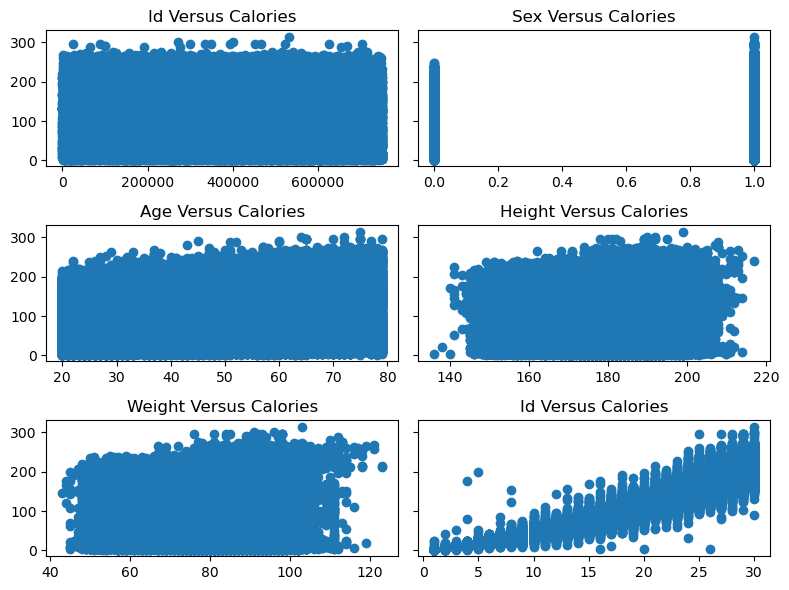

In [136]:
fig, ax= plt.subplots(figsize=(8, 6), nrows=3, ncols=2, sharey='all')
ax[0, 0].scatter(x_0['id'], x_0['Calories'])
ax[0, 0].set(title='Id Versus Calories')
ax[0, 1].scatter(x_0['Sex'], x_0['Calories'])
ax[0, 1].set(title='Sex Versus Calories')
ax[1, 0].scatter(x_0['Age'], x_0['Calories'])
ax[1, 0].set(title='Age Versus Calories')
ax[1, 1].scatter(x_0['Height'], x_0['Calories'])
ax[1, 1].set(title='Height Versus Calories')
ax[2, 0].scatter(x_0['Weight'], x_0['Calories'])
ax[2, 0].set(title='Weight Versus Calories')
ax[2, 1].scatter(x_0['Duration'], x_0['Calories'])
ax[2, 1].set(title='Id Versus Calories')
plt.tight_layout();

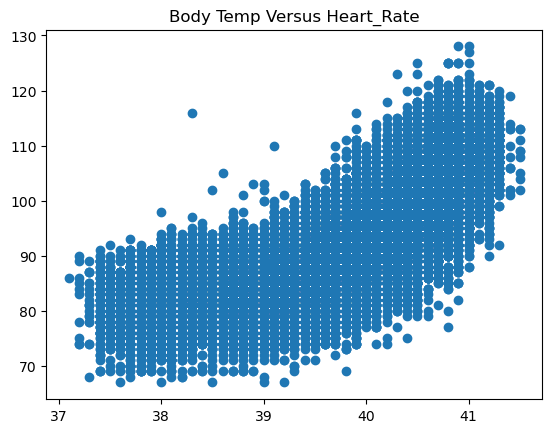

In [137]:
plt.scatter(x_0['Body_Temp'], x_0['Heart_Rate'])
plt.title('Body Temp Versus Heart_Rate');

In [138]:
## Split train data into x and Y 
x = train_df.drop('Calories', axis=1)
y = train_df['Calories']

## Split the data into train and validation set
np.random.seed(42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# instantiate the model 
model = Ridge()
model.fit(x_train, y_train)

# make predictions
y_preds = model.predict(x_val)



In [139]:
print("Min y_val:", np.min(y_val))
print("Min y_preds:", np.min(y_preds))


Min y_val: 1.0
Min y_preds: -46.022040316795255


In [140]:
def rmsle(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log(y_true + 1) - np.log(y_pred_clipped + 1)) ** 2))

RMSLE = rmsle(np.clip(y_val, 0, None), y_preds)
print(f'Valid RMSLE: {RMSLE:.2f}')

test_preds = model.predict(test_df)

Valid RMSLE: 0.57


In [141]:
y_preds

array([197.08232161,  67.28813168,  41.105076  , ...,  44.42208239,
        27.67086099, 166.0887927 ], shape=(150000,))

In [142]:
test_preds

array([ 21.35559096, 114.62936307,  93.17151899, ...,  76.18855651,
       171.80045383,  88.40022209], shape=(250000,))

In [143]:
model.score(x_val, y_val)

0.9684454501805291

## Hyperparameter Tunning
* let's use RandomizedSearchCV and GridSearchCV

In [144]:
## Let's set the grid param for ridge 

ridge_grid = {'alpha': [1e-10, 1e-5, 1e5, 1e10, 1e15, 1e20]}

## let's tune the model
gs_ridge = GridSearchCV(model,
                        cv=5,
                        param_grid=ridge_grid,
                        verbose = True)

gs_ridge.fit(x_train, y_train)
y_preds = gs_ridge.predict(x_val)
RMSLE = rmsle(y_val, y_preds)
print(f'Valid RMSLE: {RMSLE:.2f}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Valid RMSLE: 0.57


In [145]:
y_pred = gs_ridge.predict(test_df)
y_pred

array([ 21.35544683, 114.62933758,  93.17145654, ...,  76.18851337,
       171.80050724,  88.40024579], shape=(250000,))

In [146]:
gs_ridge.best_params_

{'alpha': 1e-05}

In [147]:
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log(y_true + 1) - np.log(np.clip(y_pred, 0, None) + 1)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

model_1 = Ridge(alpha=1e-5)
cross_val = cross_val_score(model_1, x, y, cv=5, scoring=rmsle_scorer)
RMSLE = np.mean(-cross_val)  # Note the negative sign
print(f'Root Mean Squared Logarithmic Error: {RMSLE:.2f}')


Root Mean Squared Logarithmic Error: 0.57


In [151]:
## Let's form our submission dataframe 

Calories_pred = pd.DataFrame({'id': test_df['id'], 'Calories': y_pred.squeeze()})
Calories_pred


,id,Calories
0,750000,21.355447
1,750001,114.629338
2,750002,93.171457
3,750003,130.755778
4,750004,73.617248
...,...,...
249995,999995,22.992315
249996,999996,8.715739
249997,999997,76.188513
249998,999998,171.800507


In [152]:
Calories_pred.to_csv('Final_Data_1.csv', index=False)